# REDES NEURONALES PROFUNDAS
Utilice el conjunto de datos Fashion-MNIST para construir un clasificador de imágenes de productos. Para la construcción del modelo utilice los tres esquemas que se describen a continuación y compare los resultados:

1. Entrenamiento de un perceptrón multicapa.
2. Entrenamiento de un undercompleted autoencoder para realizar una reducción de la dimensionalidad. Sobre el nuevo conjunto de características construya el modelo de clasificación con un perceptrón multicapa.
3. Entrenamiento de un denoising autoendoder para preentrenar una red profunda. Reuse lasprimeras capas de este autoencoder para construir un perceptron multicapa (con solo el 10% de los datos).

Para los puntos 2) y 3) compruebe, y muestre con ejemplos, que las imágenes están bien reconstruidas.

## OBJETIVO
Aplicar el proceso de aprendizaje a partir de datos para resolver problemas de clasificación utilizando redes neuronales profundas, sobre la herramienta Keras.

## DATOS
Incluidos en Keras.
Tambien, existe otra fuente equivalente que se consigue en el siguiente URL https://www.kaggle.com/zalando-research/fashionmnist donde hay un resumen de estos datos en el archivo CVS y XLSX.

la clasificacion para el aprendizaje supervisado es:

    Label 	Class
    0 	 	T-shirt/top
    1 	 	Trouser
    2 	 	Pullover
    3 	 	Dress
    4 	 	Coat
    5 	 	Sandal
    6 	 	Shirt
    7 	 	Sneaker
    8 	 	Bag
    9 	 	Ankle boot

**Importante: justifique cada decisión tomada y presente un análisis de los resultados obtenidos.**
### Consideraciones
- Utilice sólo los conjuntos de datos que se indican.
- El frameworks a utilizar es Keras con Jupyter Notebbooks.
- El taller debe ser realizado en grupos de tres personas.
- Entregables: archivos ipynb (comentados, con la justificación de las decisiones consideradas y análisis de resultados).

### Enlaces de Interes
- Ejemplos de Talos https://nbviewer.jupyter.org/github/autonomio/talos/tree/master/examples/
- Articulo sobre el uso de Talos https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53
- Portal oficial de Talos https://autonomio.github.io/docs_talos/#introduction
- Github Talos https://github.com/autonomio/talos/tree/master/talos/scan
- Documentacion de github Talos https://github.com/autonomio/talos/tree/master/docs
- Documentacion Keras https://keras.io/models/sequential/
- Ejemplo 1 Autoencoder denoising https://github.com/deanwetherby/keras-denoising-autoencoder/blob/master/Denoising%20Autoencoder.ipynb
- Ejemplo 2 Autoencoder denoising https://www.kaggle.com/nathra/fashion-mnist-convolutional-autoencoder
- Ejemplo 3 Autoencoder denoising https://medium.com/analytics-vidhya/building-a-convolutional-autoencoder-using-keras-using-conv2dtranspose-ca403c8d144e
- Ejemplo 4 Autoencoder denoising https://www.kaggle.com/anmour/convolutional-autoencoder-with-keras

In [1]:
# importando dependencias de trabajo
# se importa OS, pandas y numpy para leer y preparar datos
import os
from collections import OrderedDict
from collections import Counter
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import pandas_profiling as profile
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras

# los modelos de aprendizaje con las diferentes librerias
import talos
from keras.models import load_model
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import InputLayer
from keras.models import Model
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from keras.layers import BatchNormalization

# otras librerias para manejo de experimentos, pruebas, optimizacion y otros
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


### Cargar archivos
Para cargar los datos necesarios se siguen los siguientes pasos:

 - Se cargan los datos desde el conjunto de datos incluido en Keras

 - Se crean diccionarios de referencia para el pruebas y entrenamiento.
 - Se leen los arhivos de pruebas y entrenamiento para crear un set de datos.
 - Se transforma cada uno de los archivos en matrices de datos y se adicionan a los conjuntos de pruebas y entrenamiento.

In [2]:
# lista de nombres de las clasificaciones
classNamesList = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [3]:
# se carga el archivo de datos de trabajo por medio de Keras
fashionSource = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashionSource.load_data()

In [4]:
# nombres de columnas para el dataframe de pandas
columns = ["ID", "Data", "NormData", "NoiseData", "ReshapeData", "Label", "Class", "DataSize", "ReshapeSize"]
X_Data = np.concatenate((X_train, X_test), axis = 0)
y_Data = np.concatenate((y_train, y_test), axis = 0)

In [5]:
# puedo hacer otra forma de aprendizaje reorganizando los grupos de prueba y entrenamiento para ver si existe algun cambio de comportamiento.
# dataset para entrenamiento
trainData = pd.DataFrame()

# preparar datos dataset entrenamiento
for col in columns:
    
    # creo el ID del set
    if col is "ID":
        
        IDList = list(range(len(X_Data)))
        trainData[col] = IDList

    # datos de la imagen (nxm) para utilizarlos en el algoritmo de aprendizaje
    elif col is "Data":
        
        dataList = np.array(X_Data).astype(float)
        trainData[col] = list(dataList)

    # datos de la imagen (nxm) para utilizarlos en el algoritmo de aprendizaje
    elif col is "NormData":
        
        normList = np.array(X_Data).astype(float)
        maxValue = normList.max()
        normList = normList/maxValue
        normList = np.reshape(normList, (len(normList), 28, 28))
        trainData[col] = list(normList)
    
    # datos de imagen con ruido gaussiano y aplicando el reajuste
    elif col is "NoiseData":
        
        nfactor = 0.25
        prepData = np.array(X_Data).astype(float)
        maxValue = normList.max()
        prepData = prepData/maxValue
        nrange = np.array(X_Data).shape
        noiseData = nfactor*np.random.normal(loc = 0.0, scale = 1.0, size = nrange)
        noiseList = np.add(prepData, noiseData)
        noiseList = np.clip(noiseList, 0.0, 1.0)
        trainData[col] = list(noiseList)
    
    # datos de la imagen (nxm) de con cambio de forma(reshape) para poder ser utilizados en el algoritmo de aprendizaje
    elif col is "ReshapeData":
        
        reshapeData = list()
        
        for data in list(trainData["NormData"]):
            
            tempImg = data.astype(float)
            reshapeData.append(list(tempImg))
        
        reshapeData = np.array(reshapeData)
        reshapeData = reshapeData.reshape(len(reshapeData), -1)
        trainData[col] = list(reshapeData)
        
    # categoria de la imagen en entero
    elif col is "Label":
        
        nameList = list(y_Data)
        trainData[col] = nameList
    
    # nombre de la categoria/clase de la imagen
    elif col is "Class":
        
        classList = list()
        
        for data in np.nditer(y_Data):
            
            tempClass = classNamesList[data]
            classList.append(tempClass)
        
        classList = np.array(classList)
        trainData[col] = list(classList)

    # tamanho de pixeles de la matriz que representa la imagen (nxm)
    elif col is "DataSize":

        sizeList = list()
                
        for data in list(X_Data):
            
            tempSize = data.shape
            sizeList.append(tempSize)
        
        sizeList = np.array(sizeList)
        trainData[col] = list(sizeList)
    
    # tamanho dee pixales en 1D
    elif col is "ReshapeSize":
        
        reshapeList = list()
        dataList = trainData["ReshapeData"]
        dataList = np.array(dataList)
        dataList = list(dataList)

        for data in dataList:
            
            tempReshape = np.array(data.shape)
            reshapeList.append(tempReshape)

        dataList = np.array(reshapeList)
        trainData[col] = list(reshapeList)#.tolist()

In [6]:
# probando def de dataframe entrenamiento
trainData.head()

,ID,Data,NormData,NoiseData,ReshapeData,Label,Class,DataSize,ReshapeSize
0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.3750231730220056, 0.0, 0.05156751717306366...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9,Ankle boot,"[28, 28]",[784]
1,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392156862745098...","[[0.2718962753222339, 0.0, 0.0, 0.383056601930...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392156862745098,...",0,T-shirt/top,"[28, 28]",[784]
2,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.006537600324446669, 0.18545...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,T-shirt/top,"[28, 28]",[784]
3,3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12...","[[0.09915371818863275, 0.07160150058964104, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.129...",3,Dress,"[28, 28]",[784]
4,4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.34092691516236673, 0.0, 0.0, 0.105635...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,T-shirt/top,"[28, 28]",[784]


In [7]:
# probando tipos de dataframe entrenamiento
trainData.dtypes

ID              int64
Data           object
NormData       object
NoiseData      object
ReshapeData    object
Label           int64
Class          object
DataSize       object
ReshapeSize    object
dtype: object

## AUTOCODIFICADOR-D (AUTOENCODER DENOISING)

In [8]:
# se remueve la clase a predecir y demas columnas innecesarias
dropColumns = ["DataSize", "ReshapeSize", "ReshapeData", "Data"]
encoderData = trainData.drop(columns = dropColumns, axis = 1)

In [9]:
# pruebo nueva representacion de los datos
encoderData.head()

,ID,NormData,NoiseData,Label,Class
0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.3750231730220056, 0.0, 0.05156751717306366...",9,Ankle boot
1,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392156862745098...","[[0.2718962753222339, 0.0, 0.0, 0.383056601930...",0,T-shirt/top
2,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.006537600324446669, 0.18545...",0,T-shirt/top
3,3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12...","[[0.09915371818863275, 0.07160150058964104, 0....",3,Dress
4,4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.34092691516236673, 0.0, 0.0, 0.105635...",0,T-shirt/top


In [112]:
# asigno variables para el entrenamiento del autoencoder
X_encoder = np.array(encoderData["NoiseData"])
y_encoder = np.array(encoderData["NormData"])
# X_encoder = X_encoder.reshape(-1,28,28,1)

noiseList = list()
encoderList = list()

for data in list(X_encoder):
    data = np.reshape(data,(28,28,1))
    noiseList.append(data)

for data in list(y_encoder):
    data = np.reshape(data,(28,28,1))
    encoderList.append(data)
    
X_encoder = np.array(noiseList)
y_encoder = np.array(encoderList)

In [159]:
# agrego las capas necesarias para el modelo Keras para el Autoencoder
# parametros para las capas
neurons = trainData["ReshapeSize"][0]
output = trainData["ReshapeSize"][0]
inn = "relu"
act = "relu"
out = "relu" # "relu"
pool = (2,2)
ldrop = 0.2

# forma de entrada de los datos para las capas de entrada, salida y aprendizaje
# inshape = list(trainData["DataSize"][0],)
inshape = list(trainData["ReshapeSize"][0],)
outshape = list(trainData["ReshapeSize"][0],)
lshape = list(trainData["ReshapeSize"][0],)

# parametros para compilar
# se selecciona Mean Squared Error (MSE) con datos estandarizados (imagen en escala de grises 0 a 255)
l = "mse"
opti = "adam" # "adam" "adadelta" "nadam"
met = ["accuracy"]

# parametros para mirar el progreso del entrenamiento
ver = 1
epo = 10
batch = 256

### Definición de las capas del AUTOENCODER
Para el AUTOENCODER se definen las siguientes capas:

-	Una capa de entrada “input_img” y forma de entrada (28,28,1).
-	Una primera capa de codificación  “Conv2D”.
-	Una segunda capa de codificación  “Conv2D”.
-	Una capa intermedia de hallazgos/aprendizaje “Conv2D”.
-	Una primera capa de decodificación  “Conv2D”.
-	Una primera capa de decodificación  “Conv2D”.
-	Una capa de salida “Conv2D” con 784 y función de activación “relu”.
-	Unas capas “MaxPooling2D” entre cada capa de aprendizaje para evitar un sobre ajuste del modelo.
-	Todas las capas de aprendizaje (codificación, decodificación e intermania) tiene una funcion de activación “relu” para evitar la saturación de la salida de las capas.

In [207]:
# definicion de Keras para el AUTOENCODER
# create the encode network
input_img = Input(shape = (28,28,1), name = "in_layer")
x = Conv2D(32, 3, 3, activation = inn, border_mode = 'same', input_shape = (1,28,28))(input_img)
x = MaxPooling2D((2,2), border_mode = 'same')(x)
x = Conv2D(16, 3, 3, activation = act, border_mode = 'same',input_shape = (1,28,28))(x)
encoded = MaxPooling2D((2,2), border_mode = 'same')(x)

In [208]:
# create the decode network
x = Conv2D(16, 3, 3, activation = act, border_mode = 'same', input_shape = (1,28,28), name = "mid_layer")(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, 3, 3, activation = act, border_mode = 'same', input_shape = (1,28,28))(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, 3, 3, activation = out, border_mode = 'same', input_shape = (1,28,28), name = "out_layer")(x)

In [209]:
# create the autoencoder by tying the encode and decode networks together
noisyEncoder = Model(input_img, decoded)
noisyEncoder.compile(optimizer = opti, loss = l)
noisyEncoder.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in_layer (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
mid_layer (Conv2D)           (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampling2d_19 (UpSampling (None, 14, 14, 16)        0  

In [210]:
# division de poblacion de entrenamiento y pruebas con los datos en un orden alternativos
X_trainE, X_testE, y_trainE, y_testE = train_test_split(X_encoder, y_encoder, test_size = 0.2, random_state = 42)

In [211]:
# compilando las condiciones de optimizacion y ajuste del MLP Keras
noisyEncoder.compile(loss = l, optimizer = opti, metrics = met)

In [212]:
# ajustando el modelo MLP Keras
historyEncoder = noisyEncoder.fit(
    x = np.array(X_trainE), 
    y = np.array(y_trainE), 
    epochs = epo, verbose = ver,
    workers = 32, use_multiprocessing = True,
    batch_size = batch,
    validation_data = (np.array(X_testE), np.array(X_testE))
)

Train on 56000 samples, validate on 14000 samples
Epoch 1/10
56000/56000 [==============================] - 151s 3ms/step - loss: 0.0449 - accuracy: 0.5034 - val_loss: 0.1396 - val_accuracy: 0.6078
Epoch 2/10
56000/56000 [==============================] - 161s 3ms/step - loss: 0.0309 - accuracy: 0.5072 - val_loss: 0.1154 - val_accuracy: 0.6371
Epoch 3/10
56000/56000 [==============================] - 184s 3ms/step - loss: 0.0294 - accuracy: 0.5076 - val_loss: 0.1208 - val_accuracy: 0.6311
Epoch 4/10
56000/56000 [==============================] - 164s 3ms/step - loss: 0.0283 - accuracy: 0.5078 - val_loss: 0.1177 - val_accuracy: 0.6381
Epoch 5/10
56000/56000 [==============================] - 169s 3ms/step - loss: 0.0278 - accuracy: 0.5079 - val_loss: 0.1140 - val_accuracy: 0.6416
Epoch 6/10
56000/56000 [==============================] - 133s 2ms/step - loss: 0.0273 - accuracy: 0.5080 - val_loss: 0.1177 - val_accuracy: 0.6356
Epoch 7/10
56000/56000 [==============================] - 133s

In [213]:
# evaluando el modelo entrenado con sus propias herramientas
evalEnconder = noisyEncoder.evaluate(np.array(X_testE), np.array(X_testE))

14000/14000 [==============================] - 8s 545us/step


In [214]:
print("Perdida: ", evalEnconder[0])
print("Precision: ", evalEnconder[1])

Perdida:  0.13010077485016414
Precision:  0.6194108724594116


In [215]:
# resumen de datos del MLP Keras
noisyEncoder.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in_layer (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
mid_layer (Conv2D)           (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampling2d_19 (UpSampling (None, 14, 14, 16)        0  

### Creando el modelo Underencoder

In [216]:
# guardo los datos del modelo entrenado 
noisyEncoder.save('noisyEncoderFashion.h5')

# cargo otro otro modelo para editarlo
underEncoder = load_model('noisyEncoderFashion.h5')

In [217]:
underEncoder.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in_layer (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
mid_layer (Conv2D)           (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampling2d_19 (UpSampling (None, 14, 14, 16)        0  

In [218]:
# borro las capas innecesarias entre la capa de salida (out_layer) y la intermedia (mid_layer)
i = len(underEncoder.layers)
denseShape = (28, 28)
extraLayers = list()
found = False

while i >= 0 and found == False and underEncoder.layers[i-1].name != "mid_layer":
    i -= 1
    
    extraLayers.append(underEncoder.layers[i].name)
    
    if underEncoder.layers[i].name == "mid_layer":
        found = True
        
    underEncoder.layers.pop()

In [219]:
underEncoder.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in_layer (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
mid_layer (Conv2D)           (None, 7, 7, 16)          2320      
Total params: 12,193
Trainable params: 12,193
Non-trainable params: 0
______________________________________________________

In [220]:
# se prueba el underencoder creado con keras y el modelo original
underPrediction = underEncoder.predict(np.array(X_testE))

In [221]:
# se prueba Autoencoder con keras
encoderPrediction = noisyEncoder.predict(np.array(X_testE))

In [222]:
maxImages = 10
randomTestImg = np.random.randint(len(X_testE), size = maxImages)

### Muestra de trabajo para el Autoencoder y el Underencoder

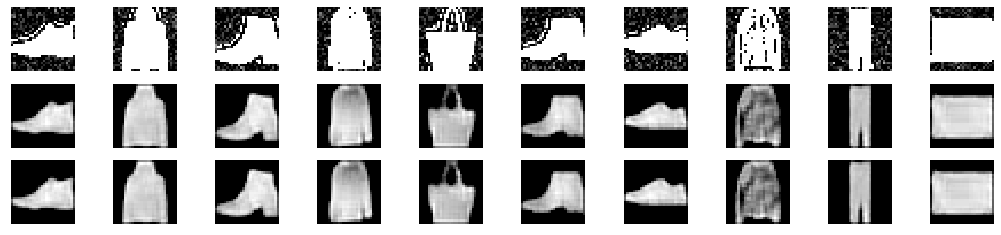

In [226]:
plt.figure(figsize=(18, 4))
originalShape = trainData["DataSize"][0]

for i, image_idx in enumerate(randomTestImg):
    # plot original image
    ax = plt.subplot(3, maxImages, i + 1)
    plt.imshow(X_testE[image_idx].reshape(originalShape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, maxImages, maxImages + i + 1)
    plt.imshow(underPrediction[image_idx].reshape(denseShape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, maxImages, 2*maxImages + i + 1)
    plt.imshow(encoderPrediction[image_idx].reshape(originalShape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

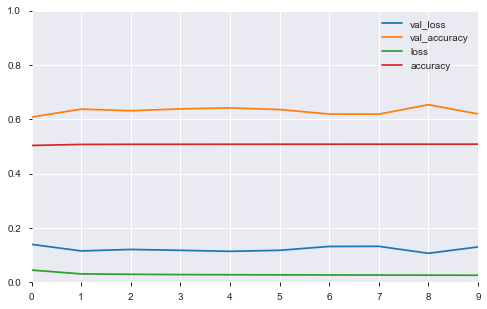

In [227]:
# curva de aprendizaje para clasificador con sklearn split
pd.DataFrame(historyEncoder.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

### Agregando Representaciones condensadas al DataFrame

Se agregan nuevas representaciones para entrenar el MLP, específicamente se crea un modelo de codificación basado en el Autoencoder para entrenar la red con los datos característicos encontrados por la otra red. Los resultados de estas operaciones de guardan en el DataFrame de entrenamiento original.

In [228]:
# se representa el conjunto de datos con la representacion condensada
dataSet = np.array(encoderData["NoiseData"])

noiseList = list()

for data in list(X_encoder):
    data = np.reshape(data,(28,28,1))
    noiseList.append(data)
    
dataSet = np.array(noiseList)


In [229]:
dataPrediction = underEncoder.predict(np.array(dataSet))

In [230]:
# se agrega la info de la informacion condensada en el dataframe de entrenamiento
denseData = list()

for data in list(dataPrediction):
#     print(data)
    tempDense = data.reshape(denseShape)
    denseData.append(tempDense)

trainData["DenseData"] = denseData

In [231]:
# se agrega la forma de la informacion condensada en el dataframe
sizeList = list()

for data in list(trainData["DenseData"]):

    tempSize = data.shape
    sizeList.append(tempSize)

sizeList = np.array(sizeList)
trainData["DenseSize"] = list(sizeList)

In [232]:
# representacion alternativa 1D de la forma condensanda en el dataframe
reshapeList = list()
dataList = np.array(trainData["DenseData"])

for data in dataList:

    tempReshape = np.array(data).flatten().shape
    reshapeList.append(tempReshape)
    
trainData["AlterSize"] = list(reshapeList)#.tolist()

In [233]:
trainData.head()
# trainData["DenseData"][0].shape

,ID,Data,NormData,NoiseData,ReshapeData,Label,Class,DataSize,ReshapeSize,DenseData,DenseSize,AlterSize
0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.3750231730220056, 0.0, 0.05156751717306366...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9,Ankle boot,"[28, 28]",[784],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[28, 28]","(784,)"
1,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392156862745098...","[[0.2718962753222339, 0.0, 0.0, 0.383056601930...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392156862745098,...",0,T-shirt/top,"[28, 28]",[784],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[28, 28]","(784,)"
2,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.006537600324446669, 0.18545...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,T-shirt/top,"[28, 28]",[784],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[28, 28]","(784,)"
3,3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 33.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12...","[[0.09915371818863275, 0.07160150058964104, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.129...",3,Dress,"[28, 28]",[784],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06894106, 0....","[28, 28]","(784,)"
4,4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.34092691516236673, 0.0, 0.0, 0.105635...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,T-shirt/top,"[28, 28]",[784],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[28, 28]","(784,)"


## PERCEPTRON MULTICAPA MODIFICADO

El MLP se modifica para tener menos neuronas y entrenarse con la representación condensada de la información (forma densa de 8x8), se espera que esta nueva representación de datos mejore el rendimiento del modelo.

In [234]:
# se remueve la clase a predecir 
dropColumns = ["ID", "Label", "Class", "DataSize", "ReshapeSize"]
#["Name", "Path", "Digit", "DataSize", "ReshapeSize"]
X = trainData.drop(columns = dropColumns, axis = 1)["DenseData"].tolist()
y = trainData["Label"].tolist()

In [235]:
# agrego las capas necesarias para el modelo Keras Perceptron Multicapa (MLP)
# parametros para las capas
neurons = 80
categories = len(classNamesList)
act = "relu"
out = "softmax"
ldrop = 0.2

# estos se cambian aparte porque se demoran mucho
# inshape = list(trainData["DataSize"].value_counts().index.tolist()[0],)
# lshape = list(trainData["ReshapeSize"].value_counts().index.tolist()[0],)
inshape = list(trainData["DenseSize"][0],)
lshape = list(trainData["AlterSize"][0],)

# parametros para compilar
l = "categorical_crossentropy"
opti = "adam"
met = ["accuracy"]

# parametros para mirar el progreso del entrenamiento
ver = 1
epo = 10

### Definición de las capas MLP
Para el MLP se definen las siguientes capas:

-	Una capa de entrada “Flatten” que recibe la imagen 2D y lo transforma a un arreglo 1D para facilidad de procesamiento.
-	Una capa de 80 neuronas “Dense” como capa de entrada para los datos con representación 1D.
-	Una capa “Dropout” con 20% de desactivación de los datos de entrada para evitar un sobre ajuste del modelo, se recalca que entre cada capa de trabajo se utiliza “Dropout” con el mismo propósito.
-	Una capa de 60 neuronas “Dense” como capa como primera capa de aprendizaje.
-	Una capa de 40 neuronas “Dense” como capa como segunda capa de aprendizaje.
-	Todas las capas de aprendizaje tienen función de activación “relu” para evitar la explosión/desvanecimiento de los gradientes.
-	Una capa con 10 neuronas “Dense” como capa de salida para clasificación con función de activación “softmax” para reconocer categorías por separado.


In [236]:
# arreglo de capas Keras para el MLP
layerList = (
    Flatten(input_shape = inshape),
    Dense(neurons, input_shape = inshape, activation = act),
    Dropout(ldrop, seed = 42),
    Dense(neurons-20, input_shape = lshape, activation = act),
    Dropout(ldrop, seed = 42),
    Dense(neurons-40, input_shape = lshape, activation = act),
    Dropout(ldrop, seed = 42),
    Dense(categories, input_shape = lshape, activation = out)
)

### Entrenamiento Preliminar
Cabe recordar que para poder entrenar el modelo multiclase se deben hacer ajustes de tipo (casts) en las entradas de los datos, en donde se transforma la matriz de datos de entrada en un array NumPy (ej.: “np.array(X_testB)”) y se transforma a categorías Dummy la salida (ej.: “to_categorical(np.array(y_testB), categories)”).

Siempre se utiliza la división aleatoria de datos después de los experimentos preliminares de la primera parte del taller.

### Con Split Random SKLearn

In [237]:
# division de poblacion de entrenamiento y pruebas con los datos en un orden alternativos
X_trainB, X_testB, y_trainB, y_testB = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [238]:
# definiendo el modelo MLP de Keras
splitClassifier = Sequential(layerList)

In [239]:
# compilando las condiciones de optimizacion y ajuste del MLP Keras
splitClassifier.compile(loss = l, optimizer = opti, metrics = met)

In [240]:
# ajustando el modelo MLP Keras
historySplit = splitClassifier.fit(
    x = np.array(X_trainB), 
    y = to_categorical(np.array(y_trainB), categories), 
    epochs = epo, verbose = ver, 
    validation_data = (np.array(X_testB), to_categorical(np.array(y_testB), categories))
)

Train on 56000 samples, validate on 14000 samples
Epoch 1/10
56000/56000 [==============================] - 7s 121us/step - loss: 0.7248 - accuracy: 0.7328 - val_loss: 0.4549 - val_accuracy: 0.8259
Epoch 2/10
56000/56000 [==============================] - 6s 110us/step - loss: 0.5283 - accuracy: 0.8090 - val_loss: 0.4304 - val_accuracy: 0.8376
Epoch 3/10
56000/56000 [==============================] - 7s 121us/step - loss: 0.4862 - accuracy: 0.8240 - val_loss: 0.4102 - val_accuracy: 0.8458
Epoch 4/10
56000/56000 [==============================] - 6s 112us/step - loss: 0.4658 - accuracy: 0.8294 - val_loss: 0.3961 - val_accuracy: 0.8526
Epoch 5/10
56000/56000 [==============================] - 7s 121us/step - loss: 0.4530 - accuracy: 0.8342 - val_loss: 0.3980 - val_accuracy: 0.8483
Epoch 6/10
56000/56000 [==============================] - 7s 120us/step - loss: 0.4440 - accuracy: 0.8387 - val_loss: 0.4117 - val_accuracy: 0.8461
Epoch 7/10
56000/56000 [==============================] - 6s 1

In [241]:
# evaluando el modelo entrenado con sus propias herramientas
evalSplit = splitClassifier.evaluate(x = np.array(X_testB), y = to_categorical(np.array(y_testB), categories))

14000/14000 [==============================] - 0s 32us/step


In [245]:
print("Perdida: ", evalSplit[0])
print("Precision: ", evalSplit[1])

Perdida:  0.37742260221072604
Precision:  0.8622857332229614


In [246]:
# resumen de datos del MLP Keras
splitClassifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                62800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)               

In [247]:
# se prueba MLP de sklearn
splitPrediction = splitClassifier.predict(np.array(X_testB))

# ajuste de las predicciones para ver el reporte de matrix de confusion
splitPrediction = np.array(splitPrediction).argmax(axis=1)

In [248]:
# Informe de los resultados para las pruebas del MLP
print("----- Reporte de Pruebas MLP con div aleatoria -----")
print("--- Conteo ---\n" + str(Counter(splitPrediction)))
print("--- Matriz de Confusion ---\n" + str(confusion_matrix(y_testB, splitPrediction)))
print("--- Reporte de Pruebas: ---")
print(classification_report(y_testB, splitPrediction))
print("--- Puntaje ---\n")
print(" - Perdida: ", evalSplit[0])
print(" - Precision: ", evalSplit[1])

----- Reporte de Pruebas MLP con div aleatoria -----
--- Conteo ---
Counter({3: 1550, 2: 1540, 4: 1485, 7: 1436, 9: 1414, 1: 1403, 5: 1397, 0: 1375, 8: 1366, 6: 1034})
--- Matriz de Confusion ---
[[1133    9   26   96    7    1  111    0   11    0]
 [   1 1363    3   27    4    0    2    0    2    0]
 [   6    2 1121   19  176    0   77    0    6    0]
 [  14   22    9 1298   78    0   24    0    4    0]
 [   0    3  207   49 1043    0   48    0    7    0]
 [   0    0    0    1    0 1374    1   56    1   16]
 [ 221    2  169   56  174    0  762    0   23    0]
 [   0    0    0    0    0   16    0 1309    1   33]
 [   0    2    4    4    3    2    9    8 1307    3]
 [   0    0    1    0    0    4    0   63    4 1362]]
--- Reporte de Pruebas: ---
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1394
           1       0.97      0.97      0.97      1402
           2       0.73      0.80      0.76      1407
           3       0.84     

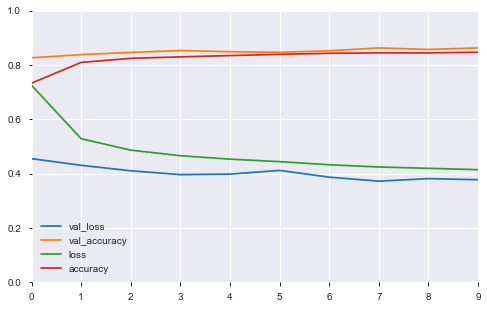

In [249]:
# curva de aprendizaje para clasificador con sklearn split
pd.DataFrame(historySplit.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

### Optimización de Hiper-parámetros

para optimizar el desempeño del Perceptrón se utiliza la librería Talos porque es relativamente fácil de crear un modelo optimizable e iterable en el espacio de hiper-parámetros definiendo una función con parámetros específicos. Para lograr esto se realizan los siguientes pasos:

 - Se define una función como modelo para el modelo de optimización Talos.
 - Se define un espacio de búsqueda de hiper-parámetros del MLP.
 - Se ejecuta una búsqueda aleatoria (opción por defecto de Talos) en una fracción reducida del espacio de hiper-parámetros del MLP.
 - Después, se analizan los resultados para obtener la mejor versión del modelo entrenado y se resume los resultados del modelo seleccionado durante el proceso de optimización.

In [250]:
# redefiniendo el modelo preliminar en funcion para optimizar
def fashionPerceptron(X_train, y_train, X_test, y_test, params):
  
    inshape = X_train[0].shape
    lshape = np.reshape(X_train[0], -1).shape
    ver = 0
    
    # definiendo el modelo MLP de Keras
    model = Sequential()
    
    # capa para representacion alternativa de (n,m) a (m*m)
    model.add(Flatten(input_shape = X_train[0].shape))

    # capa de entrada para el modelo
    model.add(Dense(params["first_neuron"], input_shape = inshape, activation = params["activation"]))
    
    # paso intermedio para hacer dropout yevitar overfit
    model.add(Dropout(params["dropout"]))
    
    # capas ocultas del modelo
    for i in range(params['hidden_layers']):
        model.add(Dense(params['hidden_neuron'], input_shape = lshape, activation = params["activation"])),
        model.add(Dropout(params['dropout']))
    
    # capa de salida del modelo
    model.add(Dense(params["last_neuron"], input_shape = lshape, activation = params["last_activation"]))
    
    # compilando las condiciones de optimizacion y ajuste del MLP Keras
    model.compile(optimizer = params["optimizer"], loss = params["losses"], metrics = ["acc"])

    # entrenando el modelo MLP Keras
    history = model.fit(
        x = np.array(X_train), 
        y = to_categorical(np.array(y_train), params["last_neuron"]), 
        epochs = params["epochs"], verbose = ver, 
        workers = 8, use_multiprocessing = True,
        batch_size = params["batch_size"],
        callbacks = [talos.utils.ExperimentLogCallback("fashionPerceptronExp", params)],
        validation_data = (np.array(X_test), to_categorical(np.array(y_test), params["last_neuron"]))
    )
    
    return history, model

In [251]:
# espacio de optimizacion de hyperparametros para el MLP
parameters = {"activation": ["relu", "elu"],
     "last_activation": ["softmax"],
     "optimizer": ["Nadam", "Adam"],
     "losses": ["categorical_crossentropy"],
     "shapes": ["brick"],
     "first_neuron": [80, 60, 40],
     "hidden_neuron": [80, 60, 40],
     "last_neuron": [len(classNamesList)],
     "hidden_layers": [0, 1, 2, 3],
     "dropout": [.1, .2, .3],
     "batch_size": [32, 64, 128],
     "epochs": [10]}

In [252]:
# se hace la busqueda con la funcion Scan()
# se utiliza el conjunto de datos reorganizado con sklearn
# la semilla random es 42 porque es la respuesta universal y es la misma en todo el codigo
# por defecto Talos hace una busqueda random, en general es mejor aunque puede caer en minimos/maximos locales
# la poblacion de busqueda aleatoria es de un 1.0% ~ 3.0% para que el procedimiento sea rapido
# para acelerar el proceso se prueba con reduction_method con correlacion y ajustandolo contra la precision de validacion
scanPerceptron = talos.Scan(x = X_trainB, y = y_trainB,
                            x_val = X_testB, y_val = y_testB,
                            model = fashionPerceptron,
                            experiment_name = "fashionPerceptronExp",
                            params = parameters, 
                            reduction_method = "correlation",
                            reduction_metric = "val_acc",
                            fraction_limit = 0.03,
                            seed = 42,
                            print_params = True)

  0%|                                                                                        | 0/38 [00:00<?, ?it/s]

{'activation': 'elu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 40, 'hidden_layers': 0, 'hidden_neuron': 80, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


  3%|██                                                                              | 1/38 [00:21<13:22, 21.68s/it]

{'activation': 'relu', 'batch_size': 128, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 80, 'hidden_layers': 2, 'hidden_neuron': 80, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


  5%|████▏                                                                           | 2/38 [00:47<13:47, 22.98s/it]

{'activation': 'relu', 'batch_size': 64, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 80, 'hidden_layers': 2, 'hidden_neuron': 60, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


  8%|██████▎                                                                         | 3/38 [01:22<15:29, 26.55s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 40, 'hidden_layers': 3, 'hidden_neuron': 40, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 11%|████████▍                                                                       | 4/38 [02:10<18:40, 32.96s/it]

{'activation': 'elu', 'batch_size': 128, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 40, 'hidden_layers': 2, 'hidden_neuron': 40, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 13%|██████████▌                                                                     | 5/38 [02:29<15:54, 28.92s/it]

{'activation': 'elu', 'batch_size': 128, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 80, 'hidden_layers': 3, 'hidden_neuron': 40, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 16%|████████████▋                                                                   | 6/38 [02:57<15:15, 28.62s/it]

{'activation': 'relu', 'batch_size': 64, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 40, 'hidden_layers': 3, 'hidden_neuron': 80, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 18%|██████████████▋                                                                 | 7/38 [03:32<15:40, 30.33s/it]

{'activation': 'elu', 'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 40, 'hidden_layers': 3, 'hidden_neuron': 40, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 21%|████████████████▊                                                               | 8/38 [04:23<18:14, 36.49s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 60, 'hidden_layers': 0, 'hidden_neuron': 80, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 24%|██████████████████▉                                                             | 9/38 [05:03<18:16, 37.81s/it]

{'activation': 'relu', 'batch_size': 64, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 60, 'hidden_layers': 2, 'hidden_neuron': 40, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 26%|████████████████████▊                                                          | 10/38 [05:38<17:12, 36.86s/it]

{'activation': 'relu', 'batch_size': 64, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 60, 'hidden_layers': 0, 'hidden_neuron': 60, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 29%|██████████████████████▊                                                        | 11/38 [06:04<15:04, 33.50s/it]

{'activation': 'elu', 'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 80, 'hidden_layers': 1, 'hidden_neuron': 60, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 32%|████████████████████████▉                                                      | 12/38 [06:58<17:09, 39.61s/it]

{'activation': 'relu', 'batch_size': 64, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 40, 'hidden_layers': 0, 'hidden_neuron': 80, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 34%|███████████████████████████                                                    | 13/38 [07:21<14:31, 34.85s/it]

{'activation': 'elu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 40, 'hidden_layers': 0, 'hidden_neuron': 80, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 37%|█████████████████████████████                                                  | 14/38 [07:43<12:22, 30.94s/it]

{'activation': 'elu', 'batch_size': 128, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 60, 'hidden_layers': 2, 'hidden_neuron': 40, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 39%|███████████████████████████████▏                                               | 15/38 [08:04<10:40, 27.83s/it]

{'activation': 'elu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 80, 'hidden_layers': 3, 'hidden_neuron': 60, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 42%|█████████████████████████████████▎                                             | 16/38 [08:46<11:45, 32.08s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 60, 'hidden_layers': 1, 'hidden_neuron': 40, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 45%|███████████████████████████████████▎                                           | 17/38 [09:36<13:06, 37.46s/it]

{'activation': 'relu', 'batch_size': 64, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 40, 'hidden_layers': 2, 'hidden_neuron': 60, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 47%|█████████████████████████████████████▍                                         | 18/38 [10:10<12:06, 36.35s/it]

{'activation': 'relu', 'batch_size': 128, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 60, 'hidden_layers': 0, 'hidden_neuron': 40, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 50%|███████████████████████████████████████▌                                       | 19/38 [10:28<09:48, 30.98s/it]

{'activation': 'relu', 'batch_size': 128, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 80, 'hidden_layers': 0, 'hidden_neuron': 60, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 53%|█████████████████████████████████████████▌                                     | 20/38 [10:47<08:14, 27.46s/it]

{'activation': 'relu', 'batch_size': 128, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 80, 'hidden_layers': 0, 'hidden_neuron': 80, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 55%|███████████████████████████████████████████▋                                   | 21/38 [11:07<07:06, 25.06s/it]

{'activation': 'elu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 40, 'hidden_layers': 0, 'hidden_neuron': 60, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 58%|█████████████████████████████████████████████▋                                 | 22/38 [11:43<07:32, 28.29s/it]

{'activation': 'elu', 'batch_size': 128, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 60, 'hidden_layers': 2, 'hidden_neuron': 80, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 61%|███████████████████████████████████████████████▊                               | 23/38 [12:06<06:40, 26.71s/it]

{'activation': 'elu', 'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 60, 'hidden_layers': 3, 'hidden_neuron': 80, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 63%|█████████████████████████████████████████████████▉                             | 24/38 [13:07<08:41, 37.23s/it]

{'activation': 'elu', 'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 80, 'hidden_layers': 3, 'hidden_neuron': 60, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 66%|███████████████████████████████████████████████████▉                           | 25/38 [14:14<09:58, 46.07s/it]

{'activation': 'relu', 'batch_size': 128, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 80, 'hidden_layers': 0, 'hidden_neuron': 60, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 68%|██████████████████████████████████████████████████████                         | 26/38 [14:32<07:31, 37.59s/it]

{'activation': 'relu', 'batch_size': 128, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 80, 'hidden_layers': 2, 'hidden_neuron': 40, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 71%|████████████████████████████████████████████████████████▏                      | 27/38 [14:54<06:03, 33.03s/it]

{'activation': 'elu', 'batch_size': 64, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 40, 'hidden_layers': 2, 'hidden_neuron': 40, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 74%|██████████████████████████████████████████████████████████▏                    | 28/38 [15:22<05:13, 31.38s/it]

{'activation': 'relu', 'batch_size': 128, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 40, 'hidden_layers': 3, 'hidden_neuron': 80, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 76%|████████████████████████████████████████████████████████████▎                  | 29/38 [15:45<04:19, 28.83s/it]

{'activation': 'elu', 'batch_size': 64, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 40, 'hidden_layers': 0, 'hidden_neuron': 80, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 79%|██████████████████████████████████████████████████████████████▎                | 30/38 [16:06<03:32, 26.61s/it]

{'activation': 'relu', 'batch_size': 128, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 80, 'hidden_layers': 2, 'hidden_neuron': 40, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 82%|████████████████████████████████████████████████████████████████▍              | 31/38 [16:27<02:54, 24.89s/it]

{'activation': 'elu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 80, 'hidden_layers': 2, 'hidden_neuron': 80, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 84%|██████████████████████████████████████████████████████████████████▌            | 32/38 [17:27<03:32, 35.42s/it]

{'activation': 'elu', 'batch_size': 64, 'dropout': 0.1, 'epochs': 10, 'first_neuron': 80, 'hidden_layers': 0, 'hidden_neuron': 60, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 87%|████████████████████████████████████████████████████████████████████▌          | 33/38 [17:57<02:49, 33.83s/it]

{'activation': 'elu', 'batch_size': 64, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 60, 'hidden_layers': 2, 'hidden_neuron': 60, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 89%|██████████████████████████████████████████████████████████████████████▋        | 34/38 [18:31<02:15, 33.96s/it]

{'activation': 'elu', 'batch_size': 128, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 80, 'hidden_layers': 0, 'hidden_neuron': 60, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 92%|████████████████████████████████████████████████████████████████████████▊      | 35/38 [18:50<01:28, 29.44s/it]

{'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 60, 'hidden_layers': 1, 'hidden_neuron': 40, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


 95%|██████████████████████████████████████████████████████████████████████████▊    | 36/38 [19:22<01:00, 30.14s/it]

{'activation': 'elu', 'batch_size': 32, 'dropout': 0.3, 'epochs': 10, 'first_neuron': 40, 'hidden_layers': 3, 'hidden_neuron': 60, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Nadam', 'shapes': 'brick'}


 97%|████████████████████████████████████████████████████████████████████████████▉  | 37/38 [20:17<00:37, 37.69s/it]

{'activation': 'elu', 'batch_size': 128, 'dropout': 0.2, 'epochs': 10, 'first_neuron': 60, 'hidden_layers': 0, 'hidden_neuron': 60, 'last_activation': 'softmax', 'last_neuron': 10, 'losses': 'categorical_crossentropy', 'optimizer': 'Adam', 'shapes': 'brick'}


100%|███████████████████████████████████████████████████████████████████████████████| 38/38 [20:33<00:00, 32.47s/it]


### Accediendo a los resultados del proceso de Optimización

In [253]:
# mirando los resultados de la optimizacion con dataFrame
scanPerceptron.data.head()

,round_epochs,val_loss,val_acc,loss,acc,activation,batch_size,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,last_activation,last_neuron,losses,optimizer,shapes
0,10,0.352015,0.869143,0.383220,0.855839,elu,64,0.2,10,40,0,80,softmax,10,categorical_crossentropy,Nadam,brick
1,10,0.361126,0.865429,0.346621,0.868821,relu,128,0.1,10,80,2,80,softmax,10,categorical_crossentropy,Nadam,brick
2,10,0.382178,0.857571,0.452120,0.837036,relu,64,0.3,10,80,2,60,softmax,10,categorical_crossentropy,Adam,brick
3,10,0.496475,0.827071,0.654799,0.761250,relu,32,0.3,10,40,3,40,softmax,10,categorical_crossentropy,Adam,brick
4,10,0.352460,0.865786,0.370819,0.862482,elu,128,0.1,10,40,2,40,softmax,10,categorical_crossentropy,Nadam,brick


In [254]:
# mirando la entropia de cada ronda de experimentos
scanPerceptron.learning_entropy.head()

,loss,acc
0,0.001220,0.000060
1,0.004627,0.000168
2,0.006424,0.000693
3,0.003294,0.001371
4,0.002260,0.000131


In [255]:
# tipos de datos dentro del set de resultados
scanPerceptron.data.dtypes

round_epochs         int64
val_loss           float64
val_acc            float64
loss               float64
acc                float64
activation          object
batch_size           int64
dropout            float64
epochs               int64
first_neuron         int64
hidden_layers        int64
hidden_neuron        int64
last_activation     object
last_neuron          int64
losses              object
optimizer           object
shapes              object
dtype: object

In [256]:
# # ver los modelos que se probaron en el proceso de optimizavion
# scanPerceptron.saved_models
    
# # ver los pesos de los modelos probados en el proceso de optimizacion
# scanPerceptron.saved_weights

# resumen del proceso de optimizacion realizado
scanPerceptron.details

experiment_name        fashionPerceptronExp
random_method              uniform_mersenne
reduction_method                correlation
reduction_interval                       50
reduction_window                         20
reduction_threshold                     0.2
reduction_metric                    val_acc
complete_time                12/01/19/20:52
x_shape                                list
y_shape                                list
dtype: object

### Analizando los resultados del proceso de Optimización
Se hacen diferentes graficas para tener perspectivas diferentes en el análisis de los resultados de la búsqueda con Talos.

In [257]:
# para el analisis se utiliza el reporte creado por Talos como entrada de Analyze
analyzePerceptron = talos.Analyze(scanPerceptron)

In [258]:
# acceso al DataFrame del analisis del reporte
analyzePerceptron.data

,round_epochs,val_loss,val_acc,loss,acc,activation,batch_size,dropout,epochs,first_neuron,hidden_layers,hidden_neuron,last_activation,last_neuron,losses,optimizer,shapes
0,10,0.352015,0.869143,0.383220,0.855839,elu,64,0.2,10,40,0,80,softmax,10,categorical_crossentropy,Nadam,brick
1,10,0.361126,0.865429,0.346621,0.868821,relu,128,0.1,10,80,2,80,softmax,10,categorical_crossentropy,Nadam,brick
2,10,0.382178,0.857571,0.452120,0.837036,relu,64,0.3,10,80,2,60,softmax,10,categorical_crossentropy,Adam,brick
3,10,0.496475,0.827071,0.654799,0.761250,relu,32,0.3,10,40,3,40,softmax,10,categorical_crossentropy,Adam,brick
4,10,0.352460,0.865786,0.370819,0.862482,elu,128,0.1,10,40,2,40,softmax,10,categorical_crossentropy,Nadam,brick
5,10,0.376184,0.858857,0.426917,0.844554,elu,128,0.2,10,80,3,40,softmax,10,categorical_crossentropy,Adam,brick
6,10,0.361381,0.862143,0.394046,0.853518,relu,64,0.1,10,40,3,80,softmax,10,categorical_crossentropy,Nadam,brick
7,10,0.425119,0.845000,0.502569,0.826232,elu,32,0.3,10,40,3,40,softmax,10,categorical_crossentropy,Nadam,brick
8,10,0.364421,0.864571,0.412665,0.847071,relu,32,0.3,10,60,0,80,softmax,10,categorical_crossentropy,Adam,brick
9,10,0.354680,0.865857,0.378511,0.859018,relu,64,0.1,10,60,2,40,softmax,10,categorical_crossentropy,Nadam,brick


In [259]:
# numero de experimentos realizados
analyzePerceptron.rounds()

38

In [260]:
# se recupera el numero del modelo con mejor puntaje, en este caso es la precision de pruetas/validacion "val_acc"
analyzePerceptron.high("val_acc")

0.8732143044471741

In [261]:
# get the round with the best result
analyzePerceptron.rounds2high("val_acc")

31

In [262]:
# imprime los mejores parametros encontrados en el proceso de optimizacion
analyzePerceptron.best_params("val_acc", ["acc", "loss", "val_loss"])

array([['elu', 'Nadam', 10, 80, 'softmax', 2, 80, 10, 'brick',
        'categorical_crossentropy', 10, 32, 0.1, 0],
       ['relu', 'Adam', 10, 60, 'softmax', 0, 80, 10, 'brick',
        'categorical_crossentropy', 10, 128, 0.1, 1],
       ['relu', 'Adam', 10, 80, 'softmax', 0, 80, 10, 'brick',
        'categorical_crossentropy', 10, 128, 0.1, 2],
       ['relu', 'Nadam', 10, 40, 'softmax', 0, 60, 10, 'brick',
        'categorical_crossentropy', 10, 128, 0.1, 3],
       ['elu', 'Nadam', 10, 80, 'softmax', 0, 40, 10, 'brick',
        'categorical_crossentropy', 10, 64, 0.2, 4],
       ['relu', 'Adam', 10, 60, 'softmax', 0, 60, 10, 'brick',
        'categorical_crossentropy', 10, 64, 0.1, 5],
       ['relu', 'Adam', 10, 80, 'softmax', 0, 40, 10, 'brick',
        'categorical_crossentropy', 10, 64, 0.1, 6],
       ['elu', 'Adam', 10, 80, 'softmax', 2, 60, 10, 'brick',
        'categorical_crossentropy', 10, 128, 0.1, 7],
       ['elu', 'Nadam', 10, 40, 'softmax', 2, 40, 10, 'brick',
     

In [263]:
# correlacion entre el puntaje y el resto de los hyperparametros
analyzePerceptron.correlate("val_loss", ["acc", "loss", "val_loss"])

round_epochs          NaN
val_acc         -0.959860
batch_size      -0.361129
dropout          0.632976
epochs                NaN
first_neuron    -0.269312
hidden_layers    0.498351
hidden_neuron   -0.249352
last_neuron           NaN
Name: val_loss, dtype: float64

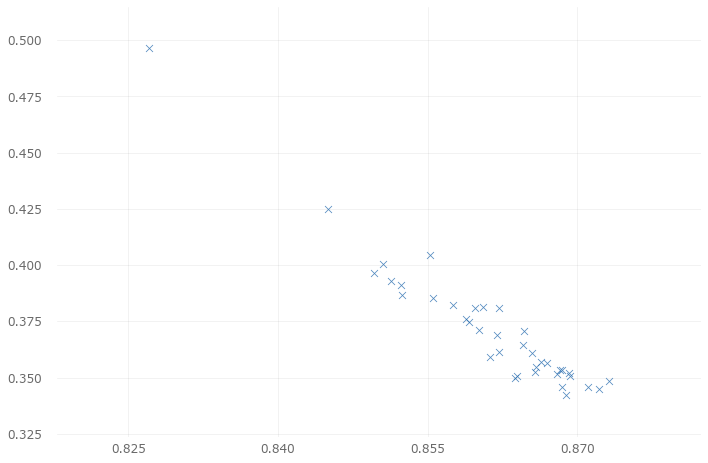

In [264]:
# a regression entre precision de puntaje/precision y perdida del conjunto de preubas
analyzePerceptron.plot_regs("val_acc", "val_loss")

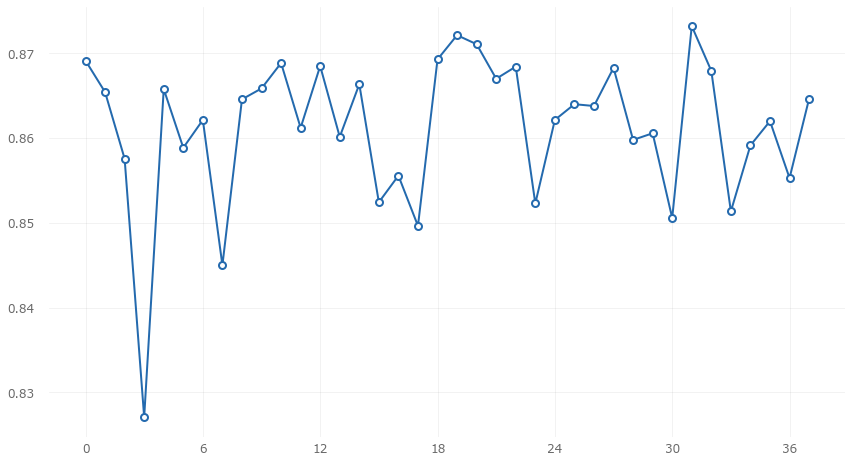

In [265]:
# linea de resultados de la precision de los experimentos
analyzePerceptron.plot_line("val_acc")

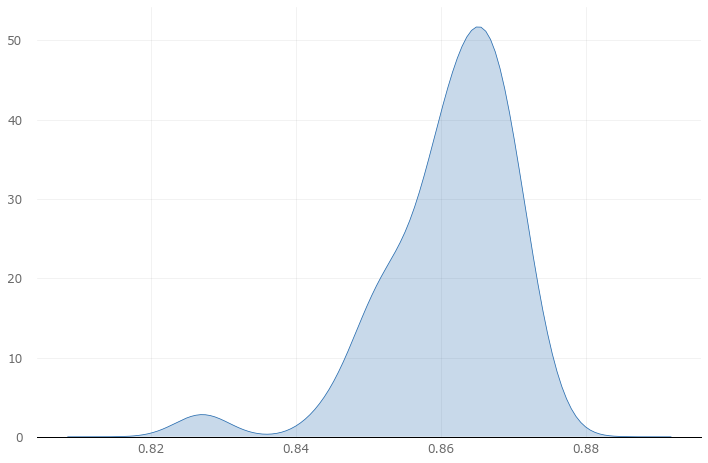

In [266]:
# distribucion de probabilidad de la precision de pruebas
analyzePerceptron.plot_kde("val_acc")

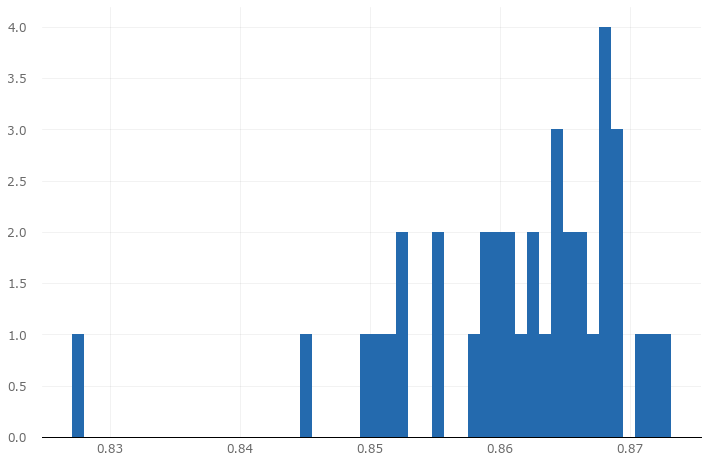

In [267]:
# histograma de la precision de pruebas de los experimentso
analyzePerceptron.plot_hist("val_acc", bins = 50)

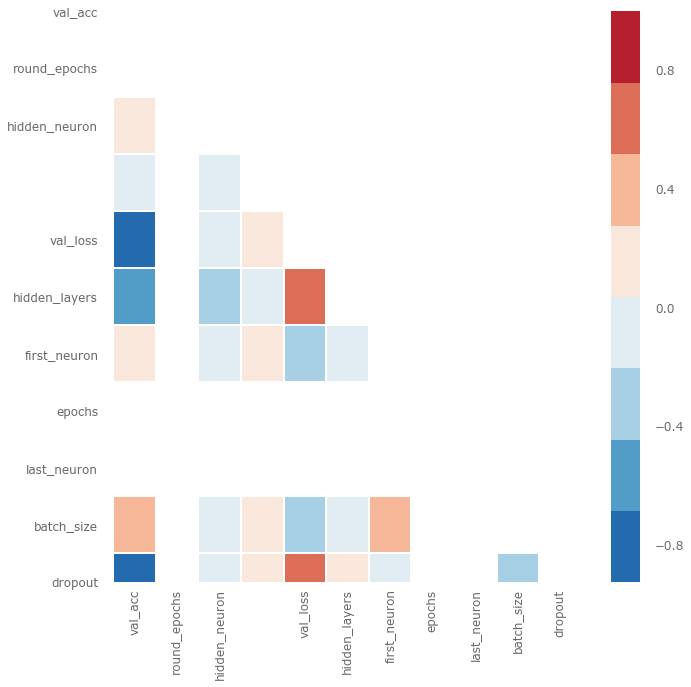

In [268]:
# mapa de correlacion para la correlacion de de la precision de preubas y otras variables
analyzePerceptron.plot_corr("val_loss", ["acc", "loss", "val_loss"])

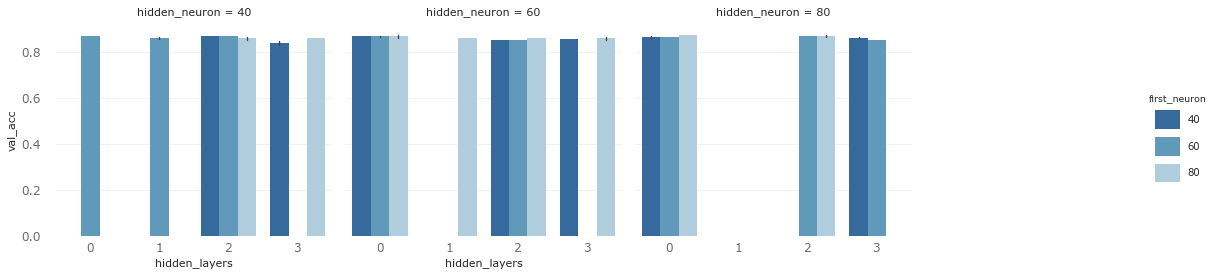

In [269]:
# grafica analizando el comportamiento de las capas ocultas, precision de pruebas, # de neuroans en la entrada y # de neuronas en la capa escondida
analyzePerceptron.plot_bars("hidden_layers", "val_acc", "first_neuron", "hidden_neuron")

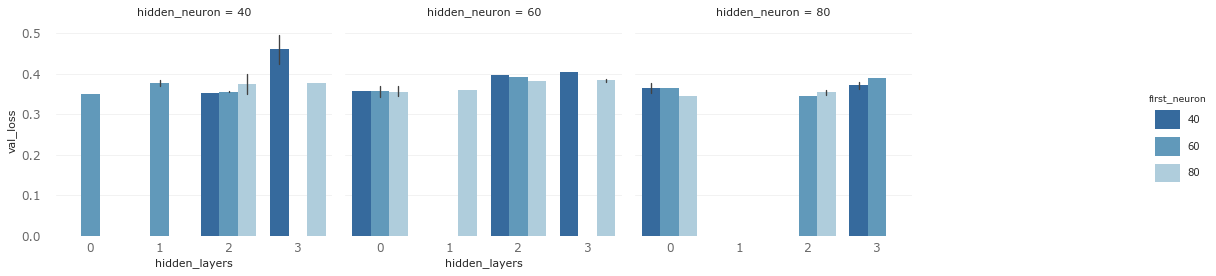

In [270]:
# grafica analizando el comportamiento de las capas ocultas, precision de pruebas, # de neuroans en la entrada y # de neuronas en la capa escondida
analyzePerceptron.plot_bars("hidden_layers", "val_loss", "first_neuron", "hidden_neuron")

### Evaluando finalmente el Modelo
por defecto Talos si no se indica el ID del modelo para evaluar, escoge el mejor.

In [271]:
# creando el objeto para evaluar con Talos
evaluatePerceptron = talos.Evaluate(scanPerceptron)

In [272]:
# evaluacion final de los datos con el mejor modelo
bestAcc = evaluatePerceptron.evaluate(np.array(X_testB), to_categorical(np.array(y_testB)), folds = 5, metric = "val_acc", task = "multi_label")

In [273]:
# resumen basico del mejor MLP
evaluatePerceptron.scan_object.best_model(metric='val_acc').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                62800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                6480      
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                6480      
_________________________________________________________________
dropout_3 (Dropout)          (None, 80)               

In [274]:
# configuracion especifica del mejor MLP
evaluatePerceptron.scan_object.best_model(metric='val_acc').get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Flatten',
   'config': {'name': 'flatten_1',
    'trainable': True,
    'batch_input_shape': (None, 28, 28),
    'dtype': 'float32',
    'data_format': 'channels_last'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 28, 28),
    'dtype': 'float32',
    'units': 80,
    'activation': 'elu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_1',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.1,
    'noise_shape': None,
    'seed': None}},
  

### Predicciones y Análisis detallado del mejor Modelo

In [275]:
# predecir resultados con el mejor modelo
predictPerceptron = talos.Predict(scanPerceptron, task = "multi_label")

In [276]:
# se prueba MLP de sklearn
bestPrediction = predictPerceptron.predict(np.array(X_testB))

# ajuste de las predicciones para ver el reporte de matrix de confusion
bestPrediction = np.array(bestPrediction).argmax(axis=1)

In [277]:
# Informe de los resultados para las pruebas del MLP
print("----- Reporte FINAL de Pruebas MLP -----")
print("--- Conteo ---\n" + str(Counter(bestPrediction)))
print("--- Matriz de Confusion ---\n" + str(confusion_matrix(y_testB, bestPrediction)))
print("--- Reporte de Pruebas: ---")
print(classification_report(y_testB, bestPrediction))
print("--- Puntaje ---\n")
print(" - Precision: ", str(bestAcc))
print(" - Precision Promedio: ", str(np.mean(bestAcc)))

----- Reporte FINAL de Pruebas MLP -----
--- Conteo ---
Counter({3: 1565, 4: 1557, 9: 1447, 0: 1423, 7: 1414, 5: 1382, 1: 1363, 8: 1355, 2: 1294, 6: 1200})
--- Matriz de Confusion ---
[[1174    1    6   59    6    1  137    0   10    0]
 [   5 1341    1   47    2    0    5    0    1    0]
 [   7    1 1055   23  189    0  124    0    8    0]
 [  18   13    3 1334   58    0   23    0    0    0]
 [   0    3  134   54 1112    0   50    0    4    0]
 [   0    0    0    1    0 1366    1   51    2   28]
 [ 217    2   94   37  183    0  853    0   19    2]
 [   0    0    0    0    0   11    0 1307    1   40]
 [   2    2    1   10    7    2    7    3 1307    1]
 [   0    0    0    0    0    2    0   53    3 1376]]
--- Reporte de Pruebas: ---
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1394
           1       0.98      0.96      0.97      1402
           2       0.82      0.75      0.78      1407
           3       0.85      0.92      0

# Conclusiones 

Se utiliza la estructura DataFame para guardar todas las representaciones de datos necesarias durante el ejercicio. Aunque, se establece la perdida y la precisión como medidas del rendimiento de los modelos, en el Autoencoder la precisión no es significativa y se considera tomar otra medida/método como minimizar la pérdida del modelo para poder agilizar la experimentación. Sin embargo, la precisión del Autoencoder convolucional es mucho mejor que la de la tradicional multicapa. Cabe aclarar que el tiempo de entrenamiento de este Autoencoder es mucho más extenso que el resto de los modelos debido al filtro y el volumen del kernel entre capas.

La grafica de la curva de aprendizaje en este caso es muestra un comportamiento sobre ajustado, seguramente por la gran cantidad de datos y las diferentes capas del Autoencoder convolucional. También, como sucede en el punto 2 solo al momento de reconstruir las imágenes y desplegar la representación condensada se puede ver que el modelo realmente está funcionando y reconstruyendo el grupo de datos desde las entradas con distorsión.

Como en la primera parte del taller, se observa que el modelo tiene un buen comportamiento global, pero se observa un menor rendimiento en las categorías 0 (“T-shirt/top”/camiseta), 2 (“Pullover”/buso), 4 (“Coat”/chaqueta) y 6 (“Shirt”/camisa). Esto tiene que ver con que las clases sean parecidas entre sí, y aunque la representación condensada ayuda un poco, esta también se confunde porque varias características/atributos significativos son iguales entre clases. Como, por ejemplo: el largo de las mangas, el tipo de cuello, entre otros.

En la optimización de hiper-parámetros se utiliza la librería por extensión Talos con la misma metodología que el primer punto con una búsqueda aleatoria de los mejores hiper-parámetros en el espacio. De nuevo, la precisión se selecciona como parámetro objetivo a maximizar y se usa una población de máximo 3%. Por último, se configura la búsqueda para minimizar el uso de parámetros/hiper-parámetros no significativos (correlacionados linealmente) con la precisión del modelo. Al reducir el numero de neuronas y simplificar el modelo se observó una mejora significativa en el tiempo de optimización.

El modelo final optimizado es un MLP con:

 - Una capa de entrada “Flatten” que recibe la imagen 2D y la transforma a un arreglo 1D para su procesamiento.
 - Una capa de 60 neuronas “Dense” como primera capa de aprendizaje y activación tipo “relu”
 - Entre capas de trabajo “Dropout” con 10% de desactivación para evitar sobreajustes.
 - Una capa de 40 neuronas “Dense” como capa como segunda capa de aprendizaje y activación tipo “relu”.
 - Una capa con 10 neuronas “Dense” como capa de salida para clasificación con función de activación “softmax” para reconocer categorías por separado.

La búsqueda muestra una correlación fuerte entre la precisión y la perdida de tendencia lineal, lo que coincide con la literatura. La precisión tiene un mínimo de 81% y un máximo de 86% (optimo encontrado). En promedio el rendimiento (precisión) de los modelos esta alrededor 80%. También se observa una correlación entre el tamaño de la muestra, el numero de neuronas en la capa de entrada y el número de capas ocultas. Por el contrario, el “Dropdown” no afecta significativamente el modelo ni tampoco el numero de neuronas por capa. Esto último se relaciona con la simplificación de los datos con la representación condensada. En general las soluciones son mas estables entre si, pero los modelos todavía no pueden reconocer bien las categorías confusas (0, 2, 4 y 6) y no hay cambio significativo después de la optimización, seguramente porque se utiliza la representación condensada con características fundamentales de cada categoría.
